In [40]:
import os
import sys
from NN import data, utils, create_input, datagenerator
from Models import bsie_gnn
import glob
import numpy as np
import csv
import matplotlib.pyplot as plt

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

colors = {
    "red": "#FF1F5B",
    "green": "#00CD6C",
    "blue": "#009ADE",
    "purple": "#AF58BA",
    "yellow": "#FFC61E",
    "orange": "#F28522", 
    "grey": "#A0B1BA",  
    "brown": "#A6761D"  
}

# Run Notebooks/create_test_datasets.ipynb before running this notebook.

## Load models for ensemble model

In [48]:
weight_source = "../Weights/B3LYP/GDB+S66_delta_D5"  # Loading weights trained on the cc-pVDZ/cc-pV5Z incompleteness error of the BSIE-GDB and S66x100 datasets
model_weight_filenames = glob.glob(os.path.join(weight_source, "*.hdf5"))

models = []
for filename in model_weight_filenames:
    models.append(
        bsie_gnn.get_model(
            weights_path=filename
        )
    )

In [49]:
# Utility function for evaluating model over multiple batches
def evaluate_model(model, dataset, batch_size=1000):
    batches = utils.create_batches(dataset, batch_size=batch_size)
    model_predictions = []
    for batch in batches:
        model_predictions.append(
            model(datagenerator.mol_dict_to_input(batch),training=False).numpy()
        )
    return np.vstack(model_predictions)

### Evaluate on S66

In [50]:
dataset_path = "Datasets/S66x100"
datasets = {}
for filename in glob.glob(os.path.join(dataset_path, "*.pickle")):
    key = os.path.basename(filename).split(".")[0]
    datasets[key] = data.load_dataset(filename)


predictions = {}
for key, dataset in datasets.items():
    batches = utils.create_batches(dataset, batch_size=1000)
    ensemble_predictions = []
    for model in models:
        ensemble_predictions.append(
            evaluate_model(model, dataset)
        )
    
    ensemble_predictions = np.hstack(ensemble_predictions)
    predictions[key] = np.mean(ensemble_predictions, axis=1)


z5_energies = utils.load_np_txt_files("../Data/S66x100/Energies/B3LYP/CC-PV5Z")
zd_energies = utils.load_np_txt_files("../Data/S66x100/Energies/B3LYP/CC-PVDZ")

# Convert unit from Ha to kcal/mol and add in cc-pVDZ energies
predictions["A"] = predictions["A"] * 627.5 + zd_energies["A"]  
predictions["B"] = predictions["B"] * 627.5 + zd_energies["B"]
predictions["complex"] = predictions["complex"].reshape(66,100) * 627.5 + zd_energies["C"]
predictions["ie"] = predictions["complex"] - predictions["A"].reshape(66,1) - predictions["B"].reshape(66,1)
        

Text(0.0, 0.5, 'Interaction Energy / kcal/mol')

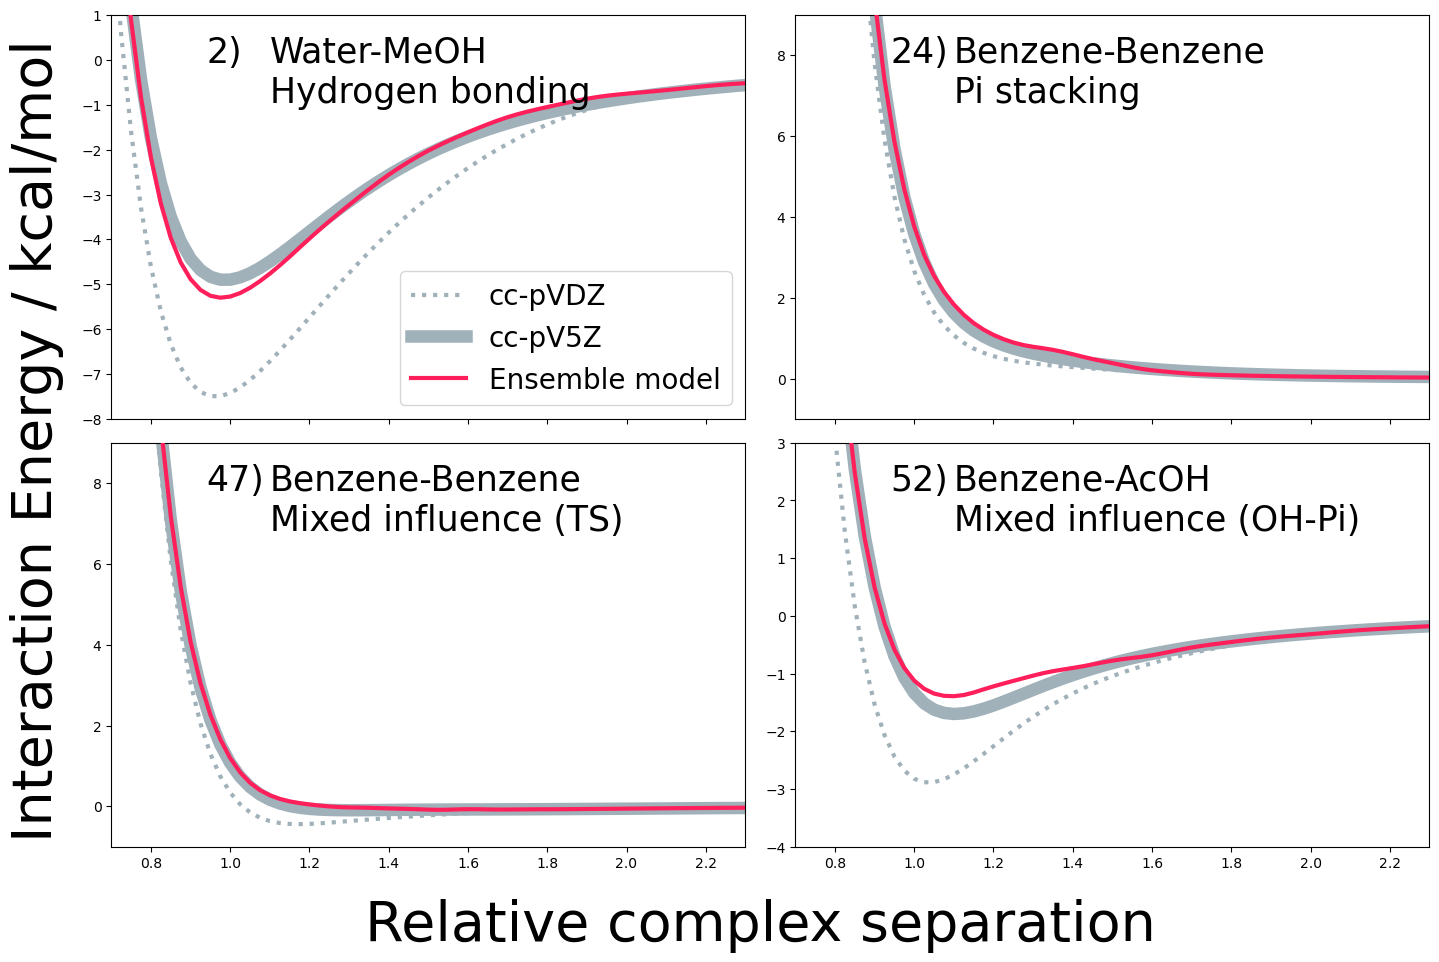

In [51]:
relative_distances = np.loadtxt("../Data/S66x100/relative_distances.txt", skiprows=1)

with open("../Data/S66x100/complexes.txt", "r") as fp:
    reader = csv.reader(fp)
    complexes = {}
    for idx, species, interaction_type in reader:
        complexes[int(idx)] = (species, interaction_type)

ylims = {
    2: (-8,1.0),
    24: (-1,9.0),
    47: (-1,9.0),
    52: (-4,3.0),
}

lw = 3
fontsize=20

n_rows, n_cols = 2, 2
fig, axs = plt.subplots(n_rows, n_cols, sharex=True, sharey=False, figsize=(15,10))
fig.tight_layout(pad=5, w_pad=0.5, h_pad=0.7)

for i, cid in enumerate([2,24,47,52]):
    row, col = np.divmod(i, n_cols)
    ax = axs[row, col]
    species, ie_type = complexes[cid]
    
    ax.plot(relative_distances, zd_energies["ie"][cid - 1], c="#A0B1BA", lw=lw, ls=":", label="cc-pVDZ", zorder=1)
    ax.plot(relative_distances, z5_energies["ie"][cid - 1], c="#A0B1BA", lw=lw + 6, label="cc-pV5Z", zorder=1)

    pred = predictions["ie"][cid - 1]
    ax.plot(relative_distances, pred, color=colors["red"], lw=lw, label=f"Ensemble model", zorder=3)

    text = f"{cid})"
    ax.text(0.15, 0.95, text, fontsize=fontsize + 5, va="top", ha="left", transform=ax.transAxes)

    text = f"{species}"
    ax.text(0.25, 0.95, text, fontsize=fontsize + 5, va="top", ha="left", transform=ax.transAxes)

    text = f"{ie_type}"
    ax.text(0.25, 0.85, text, fontsize=fontsize + 5, va="top", ha="left", transform=ax.transAxes)

    bot, top = ylims[cid]
    ax.set_ylim(bottom=bot, top=top)

axs[0,0].set_xlim(left=0.7, right=2.3)
axs[0,0].legend(fontsize=fontsize, loc="lower right")
fig.text(0.5, 0.0, "Relative complex separation", fontsize=40, ha="center")
fig.text(0.0, 0.5, "Interaction Energy / kcal/mol", fontsize=40, va="center", rotation=90)

### Evaluate Linear Hydrocarbons

In [52]:
filename = "Datasets/LinearHydrocarbons/dataset.pickle"
dataset = data.load_dataset(filename)
lin_energies = np.loadtxt("../Data/LinearHydrocarbons/Energies/B3LYP/energies.txt", skiprows=1)  # Energies are correct

# b = np.loadtxt("/home/sorenh/Datasets/Hydrocarbons/Linear/Energies/B3LYP/energies.txt")
# lin_energies == b


lin_predictions = []
batch = data.batch_mol_dicts(dataset)
input = datagenerator.mol_dict_to_input(batch)

for model in models:
    lin_predictions.append(
        model(input, training=False).numpy()
    )
lin_predictions = np.hstack(lin_predictions) * 627.5
lin_predictions = np.mean(lin_predictions, axis=1)  # Compute the mean ensemble prediction
lin_predictions = lin_predictions + lin_energies[:,1]  # Add in cc-pVDZ energies

### Evaluate PAHs

In [53]:
filename = "Datasets/PAHs/dataset.pickle"
dataset = data.load_dataset(filename)
pah_energies = np.loadtxt("../Data/PAHs/Energies/B3LYP/energies.txt", skiprows=1)


pah_predictions = []
batch = data.batch_mol_dicts(dataset)
input = datagenerator.mol_dict_to_input(batch)

for model in models:
    pah_predictions.append(
        model(input, training=False).numpy()
    )
pah_predictions = np.hstack(pah_predictions) * 627.5  
pah_predictions = np.mean(pah_predictions, axis=1)  # Compute the mean ensemble prediction
pah_predictions = pah_predictions + pah_energies[:,1]  # Add in cc-pVDZ energies

#### Plot Linear and PAHs predictions

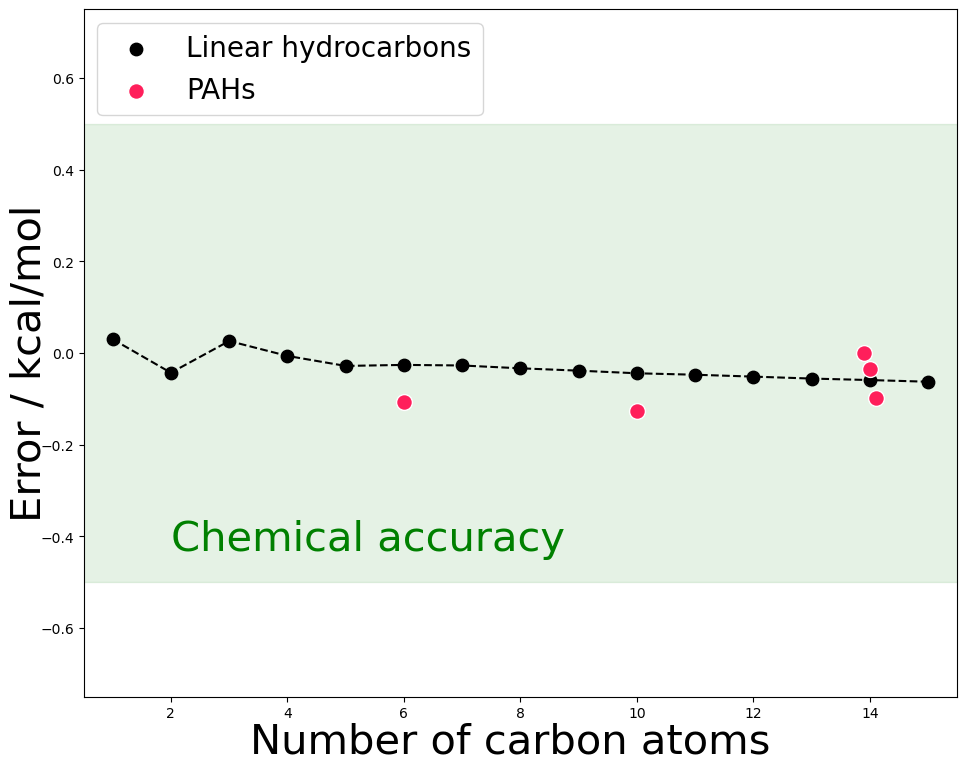

In [54]:
lin_n_carbon = np.arange(1,16)
pah_n_carbon = [6,10,14,14,14]
lin_x = lin_n_carbon
delta = 0.1
pah_x = [6, 10, 14 - delta, 14, 14 + delta]
fontsize = 20

run_lin_c = colors["grey"]
lin_c = "black"
pah_c = colors["red"]

fig, axs = plt.subplots(1, 1, sharex=True, sharey=False, figsize=(10,8))
fig.tight_layout(pad=3)

# Mean ensemble over all models
# Linear hydrocarbons
error = lin_predictions - lin_energies[:,4]
axs.plot(lin_x, error, ls="--", c=lin_c, zorder=1)
axs.scatter(lin_x, error, c=lin_c, label=f"Linear hydrocarbons", s=80, zorder=1)

# PAHs
error = pah_predictions - pah_energies[:,4]
axs.scatter(pah_x, error, c=pah_c, marker="o", label=f"PAHs", s=130, zorder=3, edgecolor="white")

# Green area
plt.fill_between([0,16], [-0.5,-0.5], [0.5,0.5], color="green", zorder=0, alpha=0.1)
axs.text(2, -0.45,"Chemical accuracy", fontsize=fontsize + 10, va="bottom", ha="left", c="green")

plt.ylim(top=0.75, bottom=-0.75)
plt.xlim(left=0.5, right=15.5)
fig.text(0.5, 0.0, "Number of carbon atoms", fontsize=fontsize + 10, ha="center", va="bottom")
fig.text(0.0, 0.5, "Error / kcal/mol", fontsize=fontsize + 10, ha="left", va="center", rotation="vertical")
axs.legend(loc="upper left", fontsize=fontsize)